## Importação das Bibliotecas

In [3]:
# -*- coding: utf-8 -*-#encoding: utf-8
from __future__ import unicode_literals

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
#from matplotlib.mlab import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import math
import time
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Entrada e Seleção dos Dados
Não iremos utilizar os dados de Valores da Fraude na Detecção, nem o atributo Time.
Usaremos como atributo alvo Class sendo 0 NÃO É FRAUDE e 1 É FRAUDE

puxar arquivo do PC

In [ ]:
#from google.colab import files
#import io
#uploaded = files.upload()
#data = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))


Puxar arquivo do drive (arquivo grande, demora bem menos)

In [4]:
# Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

entrada copiar link compartilhavel

In [5]:
id = '1HUI_gzBaWekbEhCfaMpNAxr1A2hSJLRi'

leitura do arquivo do drive

In [6]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('creditcard.csv')  
df3 = pd.read_csv('creditcard.csv')

In [109]:
data = df3
#data = pd.read_csv('creditcard.csv')
n = len(data) # Quantidade de dados da Analise
nc = 2 # Numero de Dimensões da PCA
ts = 0.6 # % de dados para Teste
df = data.iloc[:n] # split do dataset
dfc = df.drop(['Time','Class','Amount'], axis=1) # Retirada de colunas selecionadas
X = np.array(dfc.values) # Criação da Array de Atributos
y = np.array(df.Class) # Criação da Array de alvos
valores = data['Amount']

In [110]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [111]:
print(data.shape)
print(df.shape)

(284807, 31)
(284807, 31)


0    284315
1       492
Name: Class, dtype: int64

Não aprovados representam 0.17% do dataset.



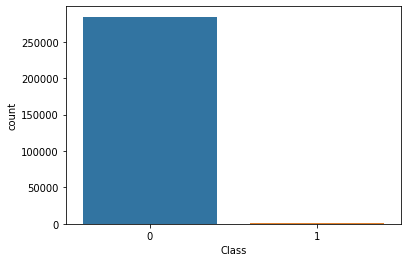

In [8]:
sns.countplot('Class', data=data);
print(data.Class.value_counts())
print("\nNão aprovados representam {:.2f}% do dataset.\n".format((data[data.Class == 1].shape[0] / data.shape[0]) * 100))

Os experimentos vão se dar nas seguintes condições:

- Tipo de Kernel da Máquina de Vetores de Suporte linear e RBF
- Também serão consideras pesos ou seja linear, linear com pesos, RBF e RBF com pesos
- Também será feita a redução de dimensionalidade usando Análise de Componente Principais (PCA)
Portanto temos os seguintes experimentos:

- SVM Linear com PCA
- SVM Linear com Pesos e PCA
- SVM Linear sem PCA
- SVM Linear com Pesos e sem PCA
- SVM RBF com PCA
- SVM RBF com Pesos e PCA
- SVM RBF sem PCA
- SVM RBF com Pesos e sem PCA

In [112]:
dfc = df.drop(['Time','Class','Amount'], axis=1) # Retirada de colunas selecionadas
X = np.array(dfc.values) # Criação da Array de Atributos
y = np.array(df.Class) # Criação da Array de alvos
valores = data['Amount']

## Experimentos com PCA
Faremos a redução de componentes de acordo com o parâmetro nc, com isso a base de atributos X será reduzida de de 28 para 2 colunas.

In [113]:
pca = PCA(n_components=nc)
X = pca.fit_transform(X)

train é o dataset da competição

In [ ]:
#train = pd.read_csv('train.csv')

In [ ]:
#sns.countplot('Class', data=train);
#print(train.Class.value_counts())
#print("\nNão aprovados representam {:.2f}% do dataset.\n".format((train[train.Class == 1].shape[0] / train.shape[0]) * 100))

## Separação da Base de Testes e de Treinamento
Vamos separar uma parte dos dados para treinamento da SVM com 60% dos dados e os outros 40% serão aplicados no modelo treinado para teste, o parâmetro ts define o % de treinamento.
teremos então as seguintes varíaveis:
- X_train = Base de atributos de treinamento COM DADOS reduzidos
- X_test = Base de atributos de teste COM DADOS NORMAIS
- y_train = Atributo alvo de treinamento (Class) COM DADOS reduzidos
- y_test = Atributo alvo de teste (Class) COM DADOS NORMAIS

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state=42)

## Undersampling 
Manter os dados minoritarios e selecionar uma qtd de dados majoritários para reduzir a diferença entre os dados e torná-los mais significativos no treinamento do modelo

In [13]:
df_train = pd.DataFrame(X_train, columns = ['PCA1', 'PCA2'])
df_train.insert(0, 'Class', y_train, True)

df_train = df_train.sample(frac=1)

In [14]:
df_train

,Class,PCA1,PCA2
55134,0,-2.219443,1.673389
8312,0,-1.073767,0.313968
100928,0,1.466901,0.026915
26176,0,0.551199,-1.242151
91318,0,0.533274,-0.692261
...,...,...,...
99847,0,0.496606,0.541320
52204,0,-1.822009,-0.168927
81461,0,3.158445,-0.476919
39012,0,-1.162273,0.386042


0    113716
1       206
Name: Class, dtype: int64

Não aprovados representam 0.18% do dataset.



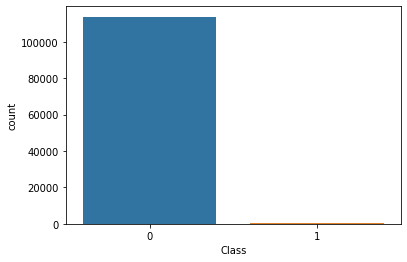

In [15]:
sns.countplot('Class', data=df_train);
print(df_train.Class.value_counts())
print("\nNão aprovados representam {:.2f}% do dataset.\n".format((df_train[df_train.Class == 1].shape[0] / df_train.shape[0]) * 100))

### Trabalhando com undersapling - formatando base em 1:4

In [16]:
# equalização de dados target = 0 e 1

qtd = 4 * 206

shuffled_df = df_train.sample(frac=1,random_state=4)

credito_concedido = shuffled_df.loc[shuffled_df['Class'] == 1]

#Randomly select 24825 observations from the non-fraud (majority class)
credito_negado = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=qtd,random_state=42)

df_train = pd.concat([credito_concedido, credito_negado])

In [17]:
X_train = df_train.drop('Class', axis=1)
y_train = df_train.Class

In [18]:
y_train.shape

(1030,)

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

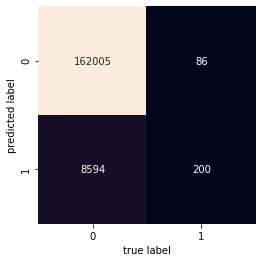

In [24]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [25]:
prob1 = model.predict_proba(X_test)
fpr1, tpr1, thresholds1 = roc_curve(y_test, prob1[:,1])
y_predRF = y_pred

CATBOOST

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

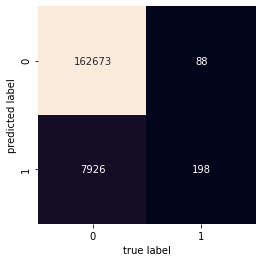

In [30]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [31]:
prob2 = model.predict_proba(X_test)
fpr2, tpr2, thresholds2 = roc_curve(y_test, prob2[:,1])
y_predCatB = y_pred

XGboost

In [32]:
import xgboost as xgb
modelX = xgb.XGBClassifier(random_state=42)
modelX.fit(X_train, y_train)
y_pred = modelX.predict(pd.DataFrame(X_test, columns=['PCA1', 'PCA2']))

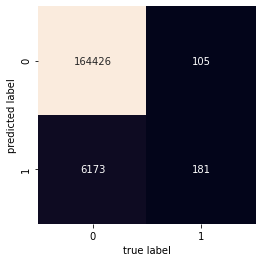

In [33]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [34]:
prob3 = model.predict_proba(pd.DataFrame(X_test, columns=['PCA1', 'PCA2']))
fpr3, tpr3, thresholds3 = roc_curve(y_test, prob3[:,1])
y_predxgb = y_pred

Light GBM

In [35]:
import lightgbm as lgb

In [36]:
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
y_pred = lgbm.predict(X_test)

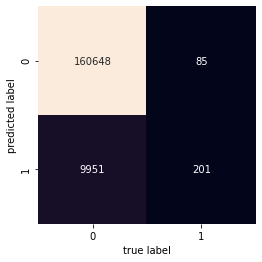

In [38]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [39]:
prob4 = lgbm.predict_proba(X_test)
fpr4, tpr4, thresholds4 = roc_curve(y_test, prob4[:,1])
y_predlgbm = y_pred

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    170599
           1       0.02      0.70      0.04       286

    accuracy                           0.94    170885
   macro avg       0.51      0.82      0.50    170885
weighted avg       1.00      0.94      0.97    170885



Parametros Curva ROC

In [41]:
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

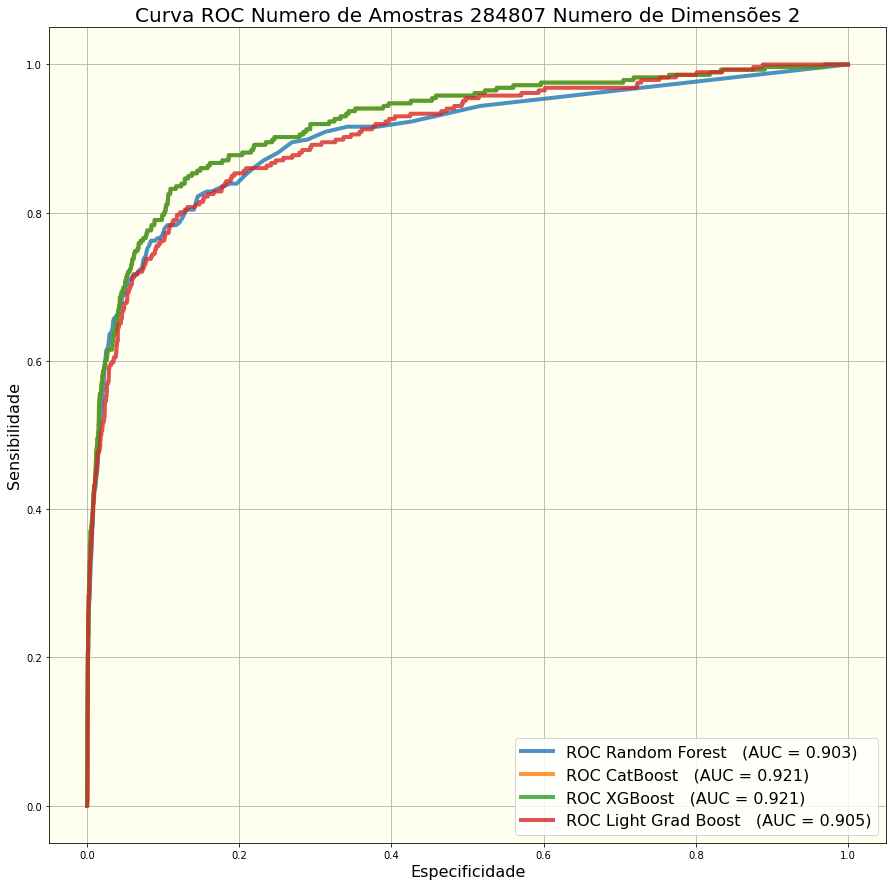

In [42]:
plt.figure(figsize=(15,15))
lw = 4.0
plt.plot(fpr1, tpr1, lw=2, alpha=0.8, linewidth = lw, label='ROC Random Forest   (AUC = %0.3f)' % (roc_auc1))
plt.plot(fpr2, tpr2, lw=2, alpha=0.8, linewidth = lw, label='ROC CatBoost   (AUC = %0.3f)' % (roc_auc2))
plt.plot(fpr3, tpr3, lw=2, alpha=0.8, linewidth = lw, label='ROC XGBoost   (AUC = %0.3f)' % (roc_auc3))
plt.plot(fpr4, tpr4, lw=2, alpha=0.8, linewidth = lw, label='ROC Light Grad Boost   (AUC = %0.3f)' % (roc_auc4))
ax = plt.gca()
ax.set_facecolor('ivory')
plt.title('Curva ROC Numero de Amostras '+str(n)+ ' Numero de Dimensões '+str(pca.n_components), fontdict = {'fontsize' : 20})
#plt.text(.10, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.20, .01, ('%.2fs' % (t3 - t2)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.30, .01, ('%.2fs' % (t5 - t4)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.40, .01, ('%.2fs' % (t7 - t6)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
plt.grid()
plt.xlabel('Especificidade', fontsize = 16)
plt.ylabel('Sensibilidade', fontsize = 16)
plt.legend(fontsize = 16)
#plt.savefig('linear_roc1.svg')

## Ajuste do Modelo SVM Linear com PCA sem Pesos

In [ ]:
plt.figure(figsize=(15,15))
lw = 4.0
plt.plot(fpr1, tpr1, lw=2, alpha=0.8, linewidth = lw, label='ROC lin   (AUC = %0.3f)' % (roc_auc1))
plt.plot(fpr2, tpr2, lw=2, alpha=0.8, linewidth = lw, label='ROC lin w (AUC = %0.3f)' % (roc_auc2))
plt.plot(fpr3, tpr3, lw=2, alpha=0.8, linewidth = lw, label='ROC rbf   (AUC = %0.3f)' % (roc_auc3))
plt.plot(fpr4, tpr4, lw=2, alpha=0.8, linewidth = lw, label='ROC rbf w (AUC = %0.3f)' % (roc_auc4))
ax = plt.gca()
ax.set_facecolor('ivory')
plt.title('Curva ROC Numero de Amostras '+str(n)+ ' Numero de Dimensões '+str(pca.n_components), fontdict = {'fontsize' : 20})
#plt.text(.10, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.20, .01, ('%.2fs' % (t3 - t2)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.30, .01, ('%.2fs' % (t5 - t4)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.40, .01, ('%.2fs' % (t7 - t6)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
plt.grid()
plt.xlabel('Especificidade', fontsize = 16)
plt.ylabel('Sensibilidade', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig('linear_roc1.svg')

In [67]:
# ajuste do modelo 1 Kernel Linear e sem pesos de balanceamento
t0 = time.time()
clf1 = svm.SVC(kernel='linear', C=1.0, probability=True) #criação de uma instância da classe SVM
model1 = clf1.fit(X_train, y_train) # Ajuste do modelo com os parâmetros de treianmento
y_pred1 = model1.predict(X_test)# Previsão do modelo com os atributos de teste
prob1 = clf1.predict_proba(X_test)# Estimativa de Probabilidades do modelo com os atributos de teste
t1 = time.time()
dt1 = t1-t0

In [45]:
dt1

0.8559525012969971

## Ajuste do Modelo SVM Linear com PCA com Pesos

In [46]:
# ajuste do modelo 2 Kernel Linear e com pesos de balanceamento
t2 = time.time()
wclf1 = svm.SVC(kernel='linear', C=1.0, class_weight={1: 25}, probability=True) #criação de uma instância da classe SVM
model2 = wclf1.fit(X_train, y_train) # Ajuste do modelo com os parâmetros de treianmento
y_pred2 = model1.predict(X_test)# Previsão do modelo com os atributos de teste
prob2 = wclf1.predict_proba(X_test)# Estimativa de Probabilidades do modelo com os atributos de teste
t3 = time.time()
dt2 = t3-t2

In [47]:
dt2

1.63315749168396

## Ajuste do Modelo SVM RBF com PCA sem Pesos

In [48]:
# ajuste do modelo 3 Kernel RBF e sem pesos de balanceamento
t4 = time.time()
clf2 = svm.SVC(kernel='rbf', C=1.0, gamma ='auto', probability=True) #criação de uma instância da classe SVM
model3 = clf2.fit(X_train, y_train) # Ajuste do modelo com os parâmetros de treianmento
y_pred3 = model3.predict(X_test)# Previsão do modelo com os atributos de teste
prob3 = clf2.predict_proba(X_test)# Estimativa de Probabilidades do modelo com os atributos de teste
t5 = time.time()
dt3 = t5-t4

In [49]:
dt3

2.598886728286743

## Ajuste do Modelo SVM RBF com PCA com Pesos

In [50]:
# ajuste do modelo 4 Kernel Linear e com pesos de balanceamento
t6 = time.time()
wclf2 = svm.SVC(kernel='rbf', C=1.0, gamma ='auto', class_weight={1: 100}, probability=True) #criação de uma instância da classe SVM
model4 = wclf2.fit(X_train, y_train) # Ajuste do modelo com os parâmetros de treianmento
y_pred4 = model4.predict(X_test)# Previsão do modelo com os atributos de teste
prob4 = wclf2.predict_proba(X_test)# Estimativa de Probabilidades do modelo com os atributos de teste
t7 = time.time()
dt4 = t7-t6

In [51]:
dt4

7.232506513595581

## Gráfico SVM Linear com PCA

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


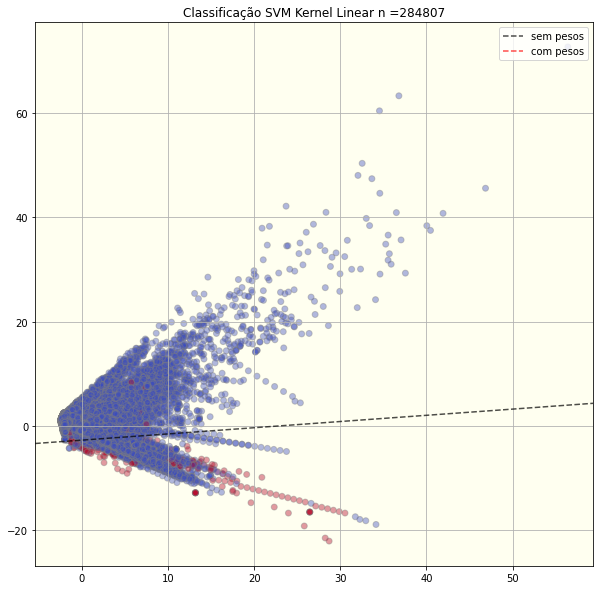

In [52]:
# Grafico das SVM com Kernel Linear

plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='gray', alpha = 0.4)
plt.grid(True)
plt.title('Classificação SVM Kernel Linear n ='+str(n))

# Camada do Grafico com as Funções de Decisão com Kernel Linea
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_facecolor('ivory')

    
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# ajuste dos Hiperplanos
Z = clf1.decision_function(xy).reshape(XX.shape)
# grafico das funções de decisão da SVM sem pesos
a = ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.7, linestyles=['--'])
# ajuste dos hiperplanos
Z = wclf1.decision_function(xy).reshape(XX.shape)
# grafico das funções de decisão da SVM com pesos
b = ax.contour(XX, YY, Z, colors='r', levels=[0], alpha=0.7, linestyles=['--'])
plt.legend([a.collections[0], b.collections[0]], ["sem pesos", "com pesos"],
               loc="upper right")
#plt.text(.99, .01, ('%.2fs' % (dt1)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
        # horizontalalignment='right')
#plt.text(.90, .01, ('%.2fs' % (dt2)).lstrip('0'),
        #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='right')
plt.savefig('linear_graph1.svg')
    


## Gráfico SVM RBF com PCA

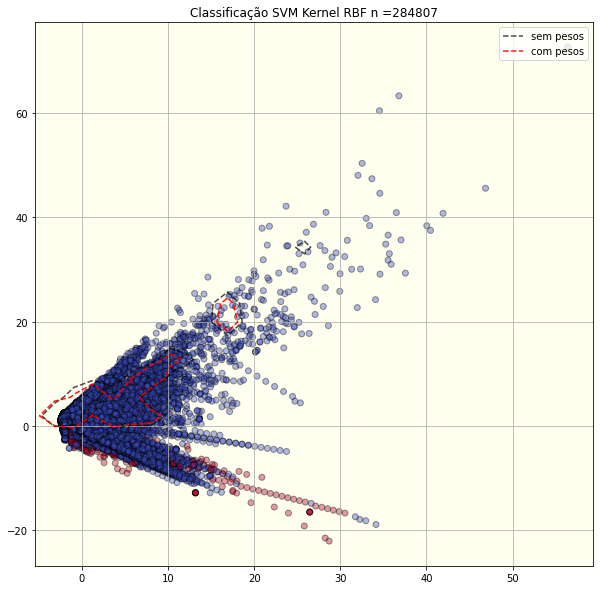

In [53]:
# plot the samples
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha = 0.4)
plt.grid(True)
plt.title('Classificação SVM Kernel RBF n ='+str(n))
# plot the decision functions for both classifiers
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_facecolor('ivory')

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# get the separating hyperplane    
Z = clf2.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
a = ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.7, linestyles=['--'])

# get the separating hyperplane for weighted classes
Z = wclf2.decision_function(xy).reshape(XX.shape)


# plot decision boundary and margins for weighted classes
b = ax.contour(XX, YY, Z, colors='r', levels=[0], alpha=0.9, linestyles=['--'])

plt.legend([a.collections[0], b.collections[0]], ["sem pesos", "com pesos"],
           loc="upper right")
#plt.text(.99, .01, ('%.2fs' % (dt3)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='right')
#plt.text(.90, .01, ('%.2fs' % (dt4)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='right')
plt.savefig('rbf_graph1.svg')

## Parâmetros Curva ROC

In [54]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, prob1[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, prob2[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, prob3[:,1])
fpr4, tpr4, thresholds2 = roc_curve(y_test, prob4[:,1])
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

## Gráfico Curva ROC

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

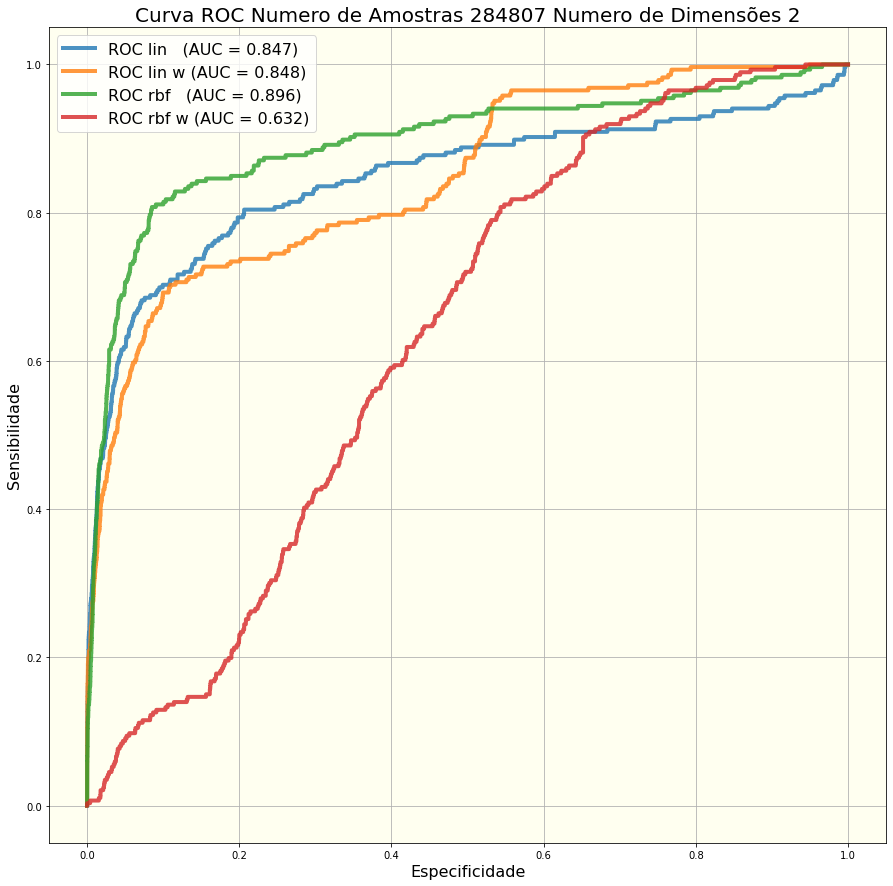

In [55]:
plt.figure(figsize=(15,15))
lw = 4.0
plt.plot(fpr1, tpr1, lw=2, alpha=0.8, linewidth = lw, label='ROC lin   (AUC = %0.3f)' % (roc_auc1))
plt.plot(fpr2, tpr2, lw=2, alpha=0.8, linewidth = lw, label='ROC lin w (AUC = %0.3f)' % (roc_auc2))
plt.plot(fpr3, tpr3, lw=2, alpha=0.8, linewidth = lw, label='ROC rbf   (AUC = %0.3f)' % (roc_auc3))
plt.plot(fpr4, tpr4, lw=2, alpha=0.8, linewidth = lw, label='ROC rbf w (AUC = %0.3f)' % (roc_auc4))
ax = plt.gca()
ax.set_facecolor('ivory')
plt.title('Curva ROC Numero de Amostras '+str(n)+ ' Numero de Dimensões '+str(pca.n_components), fontdict = {'fontsize' : 20})
#plt.text(.10, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.20, .01, ('%.2fs' % (t3 - t2)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.30, .01, ('%.2fs' % (t5 - t4)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.40, .01, ('%.2fs' % (t7 - t6)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
plt.grid()
plt.xlabel('Especificidade', fontsize = 16)
plt.ylabel('Sensibilidade', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig('linear_roc1.svg')

## Relatório de Classificação

In [65]:
def matrizConfprt(name, yPred):
  print(name)
  print(confusion_matrix(y_test, yPred))
  print (classification_report(y_test, yPred))
  print('_________________________________________________________________________ \n')


In [66]:
print('% de Fraudes no conjunto de dados ' + str(y.sum()/len(y)))
print('Quantidade de Fraudes no conjunto de doso ' + str(y.sum()))
print('% de Fraudes no conjunto treino ' + str(y_train.sum()/len(y_train)))
print('Quantidade de Fraudes no conjunto de treino ' + str(y_train.sum()))
print('% de Fraudes no conjunto de teste ' + str(y_test.sum()/len(y_test)))
print('Quantidade de Fraudes no conjunto de teste ' + str(y_test.sum()))
print('_________________________________________________________________________\n')
print('Matriz de Confusão no Teste  e relatório de classificao')
print('_________________________________________________________________________\n')
matrizConfprt('Random Forest', y_predRF)
matrizConfprt('Catboost', y_predCatB)
matrizConfprt('XGBoost', y_predxgb)
matrizConfprt('Light GBM', y_predlgbm)
matrizConfprt('SVM linear sem pesos', y_pred1)
matrizConfprt('SVM linear com pesos', y_pred2)
matrizConfprt('SVM rbf sem pesos', y_pred3)
matrizConfprt('SVM rbf com pesos', y_pred4)


% de Fraudes no conjunto de dados 0.001727485630620034
Quantidade de Fraudes no conjunto de doso 492
% de Fraudes no conjunto treino 0.2
Quantidade de Fraudes no conjunto de treino 206
% de Fraudes no conjunto de teste 0.0016736401673640166
Quantidade de Fraudes no conjunto de teste 286
_________________________________________________________________________

Matriz de Confusão no Teste  e relatório de classificao
_________________________________________________________________________

Random Forest
[[162005   8594]
 [    86    200]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    170599
           1       0.02      0.70      0.04       286

    accuracy                           0.95    170885
   macro avg       0.51      0.82      0.51    170885
weighted avg       1.00      0.95      0.97    170885

_________________________________________________________________________ 

Catboost
[[162673   7926]
 [    88    198]]
          

# **Experimentos sem PCA**






In [101]:
data = pd.read_csv('creditcard.csv')
n = len(data) # Quantidade de dados da Analise
nc = 28 # Numero de Dimensões da PCA
ts = 0.4 # % de dados para Teste


In [102]:
# diminuir dados para unseen

datav = data.sample(frac = 0.3)

In [103]:
df = datav.iloc[:n] # split do dataset
dfc = df.drop(['Time','Class','Amount'], axis=1) # Retirada de colunas selecionadas
X = np.array(dfc.values) # Criação da Array de Atributos
y = np.array(df.Class) # Criação da Array de alvos
valores = data['Amount']

In [78]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = ts, random_state=42)

In [79]:
X_train_2.shape

(25632, 28)

## Redução do tamanho da base de testes mantendo proporção

In [80]:
df_train = pd.DataFrame(X_train_2, columns = dfc.columns)
df_train.insert(0, 'Class', y_train_2, True)

df_train = df_train.sample(frac=1)

In [81]:
df_train

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
17163,0,-2.016809,1.946807,0.487543,-1.494078,-0.982375,-1.275010,0.019287,0.527979,1.272483,1.000814,-0.701334,-0.492325,-1.255191,0.074692,0.706492,0.704503,-0.502730,-0.267366,-0.938746,0.598620,-0.253450,-0.509601,0.115498,0.358537,0.033703,0.756737,0.669436,0.363203
10009,0,-2.531327,2.599981,-3.946183,-1.546995,1.349207,2.880874,-1.445439,3.092278,-0.237912,-0.693774,-0.507579,0.686209,-0.111999,0.547741,0.026544,0.750579,1.157722,-0.250819,-0.545805,0.007581,-0.247083,-1.057966,0.397499,0.576717,-0.104296,0.193090,0.052423,-0.020376
18790,0,1.091146,0.126939,1.058425,1.003429,-0.545785,0.059168,-0.414425,0.195353,-0.009691,0.064068,1.811434,1.363015,0.508014,0.244767,0.772750,0.311329,-0.542032,-0.036929,-0.645348,-0.112571,0.042639,0.155796,0.090883,0.206134,0.206124,-0.514090,0.064900,0.027372
8239,0,-1.108346,1.023950,2.008162,1.654652,-0.219299,0.431528,-0.043246,0.769791,-0.624565,-0.421533,-1.292447,-0.280985,-0.743079,0.014810,-0.809424,0.464267,-0.127862,-0.363179,-1.784054,-0.305089,0.247510,0.621865,-0.136750,0.076214,-0.048200,0.002579,-0.001541,0.047964
12742,0,-2.394639,-1.286706,0.872825,0.103626,1.190211,-0.985030,-0.853949,0.661185,0.149302,-0.866766,-1.012975,0.578597,0.997028,0.183719,0.991145,0.129051,-0.364591,0.496609,-0.058193,0.787175,0.494702,0.685599,-0.124794,0.724260,0.080038,-0.185970,0.299932,-0.178426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,0,-1.240198,0.252944,1.579210,-2.401697,-0.519971,-0.402686,-0.452129,-1.437001,-0.690241,-0.203789,-0.716273,-1.665442,-2.020010,0.030622,0.080447,1.637941,0.063124,-1.539387,-1.441226,-0.666841,1.684523,-0.241160,0.018650,-0.002324,-0.043333,-0.552154,0.203519,0.081791
22948,0,1.962680,-0.364110,-1.411405,0.299142,-0.242430,-1.345571,0.207945,-0.356905,0.574608,0.174747,-0.921453,-0.440991,-0.996215,0.651325,0.758094,0.112543,-0.428769,-0.124125,-0.221078,-0.140649,0.232763,0.596053,-0.004008,0.025531,0.004256,0.785453,-0.109478,-0.061897
16948,0,1.916529,0.180475,-1.334463,1.561406,0.202249,-0.605424,0.060004,-0.078564,0.428331,-0.174044,0.984694,0.917515,-0.340337,-0.938889,-1.217550,0.013518,0.583526,0.614469,-0.216609,-0.244125,0.102916,0.578491,-0.005482,-0.073124,0.267658,-0.480991,0.035550,-0.032278
11003,0,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,-0.165442,0.017562,0.285377,-0.818739,0.637991,-0.370124,-0.605148,0.275686,0.246362,1.331927,0.080978,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856


0    25591
1       41
Name: Class, dtype: int64

Não aprovados representam 0.16% do dataset.



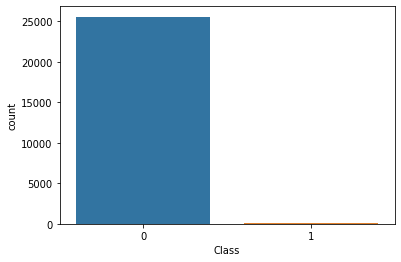

In [82]:
sns.countplot('Class', data=df_train);
print(df_train.Class.value_counts())
print("\nNão aprovados representam {:.2f}% do dataset.\n".format((df_train[df_train.Class == 1].shape[0] / df_train.shape[0]) * 100))

### Trabalhando com undersapling - formatando base em 1:4

In [84]:
# equalização de dados target = 0 e 1

qtd = 4 * 41

shuffled_df = df_train.sample(frac=1,random_state=4)

credito_concedido = shuffled_df.loc[shuffled_df['Class'] == 1]

#Randomly select 24825 observations from the non-fraud (majority class)
credito_negado = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=qtd,random_state=42)

df_train = pd.concat([credito_concedido, credito_negado])

In [85]:
X_train = df_train.drop('Class', axis=1)
y_train = df_train.Class

In [86]:
y_train.shape

(205,)

In [87]:
# ajuste do modelo 5 Kernel Linear e sem pesos de balanceamento
t8 = time.time()
clf3 = svm.SVC(kernel='linear', C=1.0, probability=True)
model5 = clf3.fit(X_train_2, y_train_2)
y_pred5 = model5.predict(X_test_2)
prob5 = clf3.predict_proba(X_test_2)
t9 = time.time()
dt5 = t9-t8

In [88]:
dt5

3.892484188079834

In [89]:
# ajuste do modelo 6 Kernel Linear e com pesos de balanceamento
t10 = time.time()
wclf3 = svm.SVC(kernel='linear', C=1.0, class_weight={1: 15}, probability=True)
model6 = wclf3.fit(X_train_2, y_train_2)
y_pred6 = model6.predict(X_test_2)
prob6 = wclf3.predict_proba(X_test_2)
t11 = time.time()
dt6 = t11-t10

In [90]:
dt6

16.245049476623535

In [91]:
# ajuste do modelo 7 Kernel RBF e sem pesos de balanceamento
t12 = time.time()
clf4 = svm.SVC(kernel='rbf', C=1.0, gamma ='auto', probability=True)
model7 = clf4.fit(X_train_2, y_train_2)
y_pred7 = model7.predict(X_test_2)
prob7 = clf4.predict_proba(X_test_2)
t13 = time.time()
dt7 = t13-t12

In [92]:
dt7

12.052433729171753

In [93]:
# ajuste do modelo 8 Kernel RBF e com pesos de balanceamento
t14 = time.time()
wclf4 = svm.SVC(kernel='rbf', class_weight={1: 100}, gamma ='auto', probability=True)
model8 = wclf4.fit(X_train_2, y_train_2)
y_pred8 = model8.predict(X_test_2)
prob8 = wclf4.predict_proba(X_test_2)
t15 = time.time()
dt8 = t15 - t14

In [94]:
dt8

9.329504251480103

In [95]:
fpr5, tpr5, thresholds5 = roc_curve(y_test_2, prob5[:,1])
fpr6, tpr6, thresholds6 = roc_curve(y_test_2, prob6[:,1])
fpr7, tpr7, thresholds7 = roc_curve(y_test_2, prob7[:,1])
fpr8, tpr8, thresholds8 = roc_curve(y_test_2, prob8[:,1])
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)
roc_auc8 = auc(fpr8, tpr8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

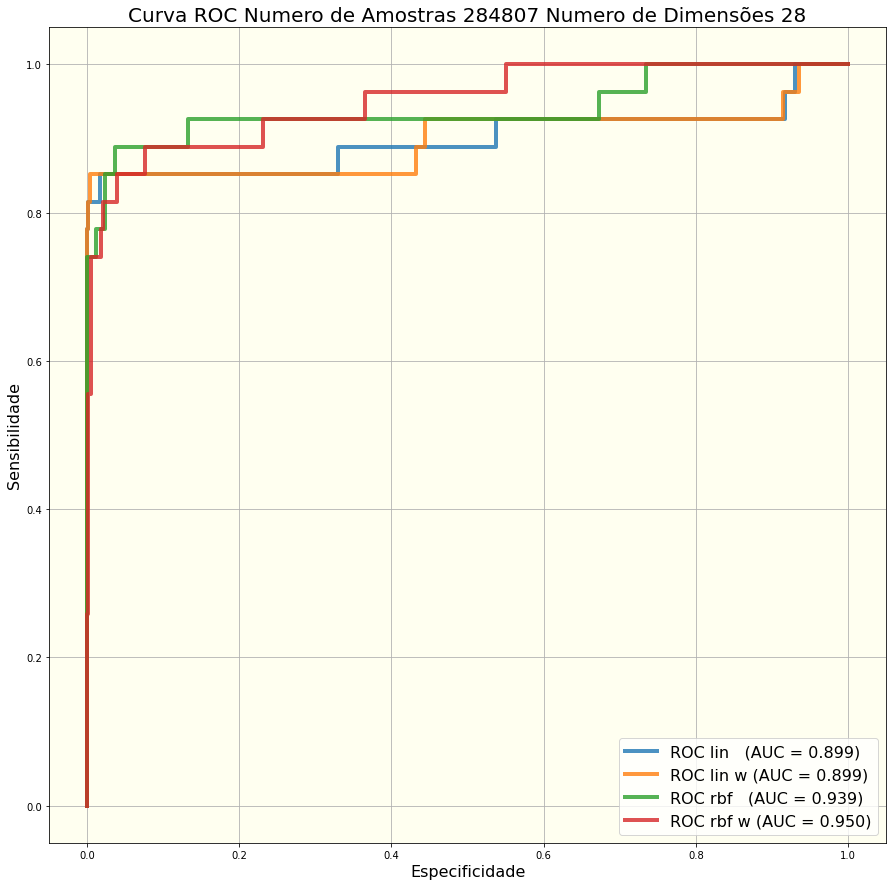

In [96]:
plt.figure(figsize=(15,15))
lw = 4.0
plt.plot(fpr5, tpr5, lw=2, alpha=0.8, linewidth = lw, label='ROC lin   (AUC = %0.3f)' % (roc_auc5))
plt.plot(fpr6, tpr6, lw=2, alpha=0.8,linewidth = lw, label='ROC lin w (AUC = %0.3f)' % (roc_auc6))
plt.plot(fpr7, tpr7, lw=2, alpha=0.8,linewidth = lw, label='ROC rbf   (AUC = %0.3f)' % (roc_auc7))
plt.plot(fpr8, tpr8, lw=2, alpha=0.8,linewidth = lw, label='ROC rbf w (AUC = %0.3f)' % (roc_auc8))

ax = plt.gca()
ax.set_facecolor('ivory')
plt.title('Curva ROC Numero de Amostras '+str(n)+ ' Numero de Dimensões '+str(nc), fontdict = {'fontsize' : 20})
#plt.text(.10, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.20, .01, ('%.2fs' % (t3 - t2)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.30, .01, ('%.2fs' % (t5 - t4)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
#plt.text(.40, .01, ('%.2fs' % (t7 - t6)).lstrip('0'),
         #transform=plt.gca().transAxes, size=15,
         #horizontalalignment='center')
plt.grid()
plt.xlabel('Especificidade', fontsize = 16)
plt.ylabel('Sensibilidade', fontsize = 16)
plt.legend(fontsize = 16)
#plt.savefig('ROC_graph.svg')

In [97]:
print('% de Fraudes no conjunto de dados ' + str(y.sum()/len(y)))
print('Quantidade de Fraudes no conjunto de doso ' + str(y.sum()))
print('% de Fraudes no conjunto treino ' + str(y_train_2.sum()/len(y_train_2)))
print('Quantidade de Fraudes no conjunto de treino ' + str(y_train_2.sum()))
print('% de Fraudes no conjunto de teste ' + str(y_test_2.sum()/len(y_test_2)))
print('Quantidade de Fraudes no conjunto de teste ' + str(y_test_2.sum()))
print('_________________________________________________________________________')
print('Matriz de Confusão no Teste')
print(confusion_matrix(y_test_2,y_pred5))
print(confusion_matrix(y_test_2,y_pred6))
print(confusion_matrix(y_test_2,y_pred7))
print(confusion_matrix(y_test_2,y_pred8))
print('_________________________________________________________________________')
print('Relatório de Classificação no Teste')
print('_________________________________________________________________________')
print('Relatório de Classificação no SVM Linear sem Pesos')
print(classification_report(y_test_2, y_pred5))
print('Relatório de Classificação no SVM Linear com Pesos')
print(classification_report(y_test_2, y_pred6))
print('Relatório de Classificação no SVM RBF sem Pesos')
print(classification_report(y_test_2, y_pred7))
print('Relatório de Classificação no SVM RBF com Pesos')
print(classification_report(y_test_2, y_pred8))

% de Fraudes no conjunto de dados 0.0015917230401910067
Quantidade de Fraudes no conjunto de doso 68
% de Fraudes no conjunto treino 0.0015995630461922597
Quantidade de Fraudes no conjunto de treino 41
% de Fraudes no conjunto de teste 0.0015799637193516297
Quantidade de Fraudes no conjunto de teste 27
_________________________________________________________________________
Matriz de Confusão no Teste
[[17060     2]
 [    8    19]]
[[17059     3]
 [    7    20]]
[[17062     0]
 [   23     4]]
[[17052    10]
 [   20     7]]
_________________________________________________________________________
Relatório de Classificação no Teste
_________________________________________________________________________
Relatório de Classificação no SVM Linear sem Pesos
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17062
           1       0.90      0.70      0.79        27

    accuracy                           1.00     17089
   macro avg     

In [98]:
p8 = prob8

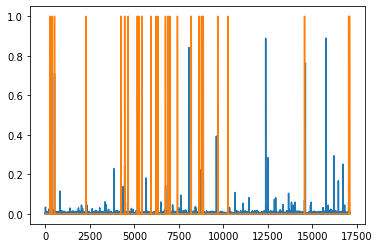

In [99]:
plt.plot(prob8[:,1])
plt.plot(y_test_2)

In [104]:
df = data.iloc[:n] # split do dataset
dfc = df.drop(['Time','Class','Amount'], axis=1) # Retirada de colunas selecionadas
X = np.array(dfc.values) # Criação da Array de Atributos


In [114]:
y_pred_t = lgbm.predict_proba(X)

In [115]:
risk = pd.DataFrame([y_pred_t[:,0], y_pred_t[:,1], valores, y])

In [116]:
risk = risk.T

In [117]:
risk.columns = ['Prob_NF', 'Prob_F', 'Valores', 'Fraude']

In [118]:
risk['Riscos'] = risk.Prob_F*risk.Valores
#risk['Prob_F'] = risk.Prob_F*100
#risk['Prob_NF'] = risk.Prob_F*100

In [119]:
risk

,Prob_NF,Prob_F,Valores,Fraude,Riscos
0,0.992885,0.007115,149.62,0.0,1.064540
1,0.999395,0.000605,2.69,0.0,0.001627
2,0.798560,0.201440,378.66,0.0,76.277262
3,0.999106,0.000894,123.50,0.0,0.110425
4,0.965883,0.034117,69.99,0.0,2.387875
...,...,...,...,...,...
284802,0.000616,0.999384,0.77,0.0,0.769525
284803,0.997213,0.002787,24.79,0.0,0.069082
284804,0.999880,0.000120,67.88,0.0,0.008137
284805,0.999949,0.000051,10.00,0.0,0.000507


In [120]:
risko = risk.sort_values(by='Riscos')

In [121]:
risko.reset_index(inplace=True, drop=True)

Text(0, 0.5, 'Valores de Risco - log')

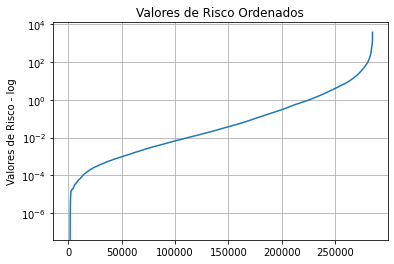

In [122]:
plt.plot(risko.Riscos.values)
plt.yscale('log')
plt.title('Valores de Risco Ordenados')
plt.grid()
plt.ylabel('Valores de Risco - log')

Text(0, 0.5, 'Valores de Probabilidadae e Impacto')

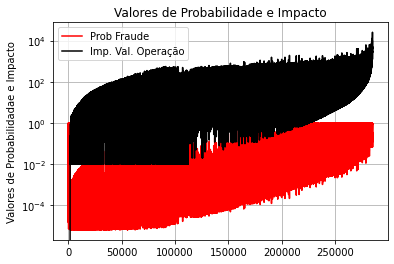

In [123]:
plt.plot(risko.Prob_F.values, label = 'Prob Fraude', color = 'red')
plt.plot(risko.Valores, label = 'Imp. Val. Operação', color = 'black')
plt.yscale('log')
plt.title('Valores de Probabilidade e Impacto')
plt.grid()
plt.legend()
plt.ylabel('Valores de Probabilidadae e Impacto')

Text(0, 0.5, 'Risco Acumulado')

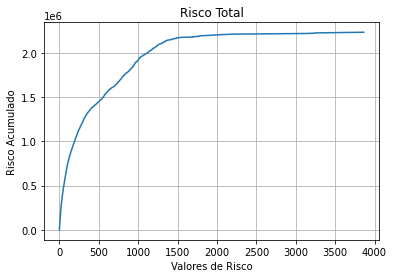

In [124]:
plt.plot(risko.Riscos.values, risko.Riscos.values.cumsum())
#plt.yscale('log')
plt.grid()
plt.title('Risco Total')
plt.xlabel('Valores de Risco')
plt.ylabel('Risco Acumulado')

In [125]:
range1 = np.linspace(0.2,1.0,100)
range2 = np.linspace(0.4,1.0,100)
range3 = np.linspace(0.6,1.0,100)
range4 = np.linspace(0.8,1.0,100)

(0.0, 1.0)

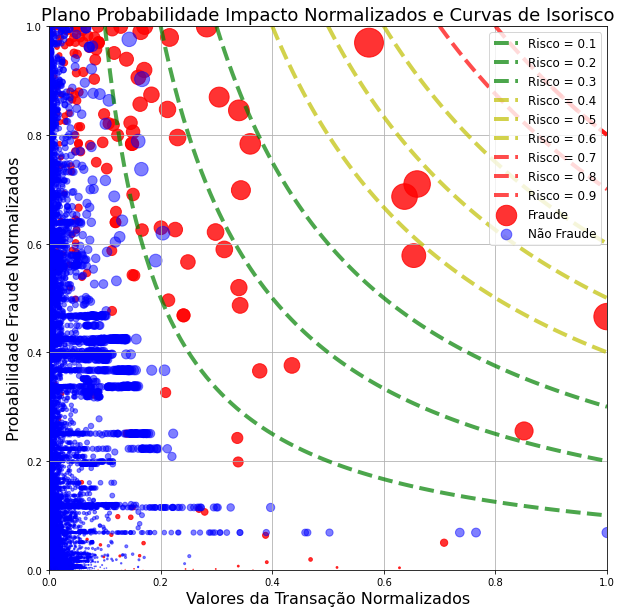

In [126]:
plt.figure(figsize=(10,10))
x1 = risko[risko['Fraude']==1.0].Valores/risko[risko['Fraude']==1.0].Valores.max()
y1 = risko[risko['Fraude']==1.0].Prob_F/risko[risko['Fraude']==1.0].Prob_F.max()
size1 = x1*y1
x0 = risko[risko['Fraude']==0.0].Valores/risko[risko['Fraude']==0.0].Valores.max()
y0 = risko[risko['Fraude']==0.0].Prob_F/risko[risko['Fraude']==0.0].Prob_F.max()
size0 = x0*y0
plt.scatter(x1, y1, s= size1*1500, color = 'red', label = 'Fraude', alpha = 0.8)
plt.scatter(x0, y0, s= size0*1500, color = 'blue', label = 'Não Fraude', alpha = 0.5)
plt.plot(np.linspace(0.1,1.0,100),0.1/np.linspace(0.1,1.0,100), 'g--', label = 'Risco = 0.1', alpha = 0.7, lw=4)
plt.plot(np.linspace(0.2,1.0,100),0.2/np.linspace(0.2,1.0,100), 'g--', label = 'Risco = 0.2', alpha = 0.7, lw=4)
plt.plot(np.linspace(0.3,1.0,100),0.3/np.linspace(0.3,1.0,100), 'g--', label = 'Risco = 0.3', alpha = 0.7, lw=4)
plt.plot(np.linspace(0.4,1.0,100),0.4/np.linspace(0.4,1.0,100), 'y--', label = 'Risco = 0.4', alpha = 0.7, lw=4)
plt.plot(np.linspace(0.5,1.0,100),0.5/np.linspace(0.5,1.0,100), 'y--', label = 'Risco = 0.5', alpha = 0.7, lw=4)
plt.plot(np.linspace(0.6,1.0,100),0.6/np.linspace(0.6,1.0,100), 'y--', label = 'Risco = 0.6', alpha = 0.7, lw=4)
plt.plot(np.linspace(0.7,1.0,100),0.7/np.linspace(0.7,1.0,100), 'r--', label = 'Risco = 0.7', alpha = 0.7, lw=4)
plt.plot(np.linspace(0.8,1.0,100),0.8/np.linspace(0.8,1.0,100), 'r--', label = 'Risco = 0.8', alpha = 0.7, lw=4)
plt.plot(np.linspace(0.9,1.0,100),0.8/np.linspace(0.9,1.0,100), 'r--', label = 'Risco = 0.9', alpha = 0.7, lw=4)

plt.grid()
plt.title
plt.xlabel('Valores da Transação Normalizados', fontsize = 16)
plt.ylabel('Probabilidade Fraude Normalizados', fontsize = 16)
plt.title('Plano Probabilidade Impacto Normalizados e Curvas de Isorisco', fontdict = {'fontsize' : 18})
plt.legend(fontsize = 12, loc = 'upper right')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
#plt.xlim([0,5000])

Text(0, 0.5, 'Probabilidade Fraude')

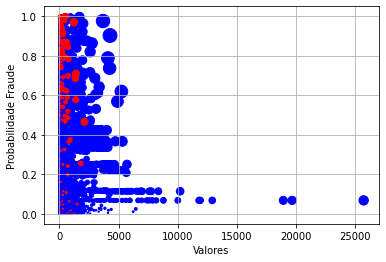

In [140]:
plt.scatter(risko[risko['Fraude']==0.0].Valores, risko[risko['Fraude']==0.0].Prob_F, s= risko[risko['Fraude']==0.0].Riscos/20, c= 'blue')
plt.scatter(risko[risko['Fraude']==1.0].Valores, risko[risko['Fraude']==1.0].Prob_F, s= risko[risko['Fraude']==1.0].Riscos/20, c= 'red')
plt.grid()
plt.xlabel('Valores')
plt.ylabel('Probabilidade Fraude')
#plt.xlim([0,50000]

(0.0, 2000.0)

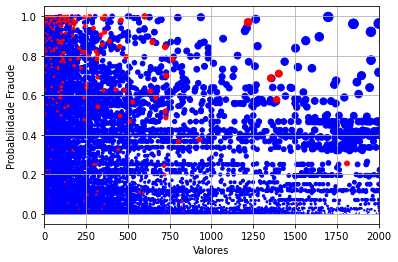

In [139]:
plt.scatter(risko[risko['Fraude']==0.0].Valores, risko[risko['Fraude']==0.0].Prob_F, s= risko[risko['Fraude']==0.0].Riscos/20, c= 'blue')
plt.scatter(risko[risko['Fraude']==1.0].Valores, risko[risko['Fraude']==1.0].Prob_F, s= risko[risko['Fraude']==1.0].Riscos/20, c= 'red')
plt.grid()
plt.xlabel('Valores')
plt.ylabel('Probabilidade Fraude')
plt.xlim([0,2000])

In [129]:
ro = [risko['Prob_NF'].values, risko['Prob_F'].values]

In [130]:
ro

[array([0.9999839 , 0.99961275, 0.96836066, ..., 0.38102097, 0.02459372,
        0.09772796]),
 array([1.61009497e-05, 3.87247112e-04, 3.16393393e-02, ...,
        6.18979034e-01, 9.75406282e-01, 9.02272039e-01])]

In [131]:
risk.to_csv('risco.csv')
from google.colab import files
files.download('risco.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>